# Center of charge mapping

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

In [3]:
def convert_pmt_ids(input_ids, conversion_ids):
    cd_ids = np.array(conversion_ids['CdID'])
    pmt_ids = np.array(conversion_ids['PMTID'])
    mask = np.isin(cd_ids, input_ids)
    return pmt_ids[mask]

## Load data

In [4]:
# PMT positions on the sphere
PMTPos_CD_LPMT    = pd.read_csv("../data/PMTPos_CD_LPMT.csv")
PMTPos_CD_LPMT.rename({"PMTID":"id"}, axis=1, inplace=True)
# PMT ID mapping
PMT_ID_conversion = pd.read_csv("../data/PMT_ID_conversion.csv")

# EVENTS
train_data        = np.load("../data/real/train/data/raw_data_train_4.npz", allow_pickle=True)["a"]
# TRUE ENERGY AND TRUE VERTEX OF THE EVENTS
train_label       = pd.read_csv("../data/real/train/targets/targets_train_4.csv")

# COMPUTE RADIUS FROM TRUE VERTEX
train_label["edepR"] = (train_label["edepX"]**2 + train_label["edepY"]**2 + train_label["edepZ"]**2)**0.5



\begin{equation}
{\displaystyle R_{xyz(?)}={\begin{pmatrix}\sin \theta \cos \varphi &\sin \theta \sin \varphi &\cos \theta \\\cos \theta \cos \varphi &\cos \theta \sin \varphi &-\sin \theta \\-\sin \varphi &\cos \varphi &0\end{pmatrix}}.}
\end{equation}




## Create a dataframe with cc in the origin

In [268]:
def R_z(theta):
    Rot = np.array([[np.cos(theta), -np.sin(theta),0],
                [np.sin(theta), np.cos(theta),0],
                [0, 0, 1]])
    return Rot

def R_x(theta):
    Rot = np.array([[1,0,0],
                [0,np.cos(theta), -np.sin(theta)],
                [0, np.sin(theta), np.cos(theta)]])
    return Rot

def R_xz(phi,theta):
    R = np.matmul(R_x(phi), R_z(theta))
    return

In [31]:
R = 19387.6557
NEvents = train_data.shape[1]
cc_df = pd.DataFrame(columns=['ev_id', 'pmt_id', 'x', 'y', 'z', 'x_new', 'y_new', 'z_new', 'charge', 'hit_time'])
ev_dfs = []

for i in range(0,10):
    # find non-zero-time hits
    nonzeros_inds = np.where(train_data[2, i] != 0.0)[0]

    ev_df = pd.DataFrame(columns=['ev_id', 'pmt_id', 'x', 'y', 'z', 'x_new', 'y_new', 'z_new', 'charge', 'hit_time'])
    ev_df['ev_id'] = pd.Series(np.repeat(i, len(nonzeros_inds)))
    # PMT ID mapping
    ev_df['pmt_id'] = pd.Series(convert_pmt_ids(train_data[0, i][nonzeros_inds], PMT_ID_conversion)) 


    coord = PMTPos_CD_LPMT[np.isin(PMTPos_CD_LPMT.id, ev_df['pmt_id'])].loc[:, ['x', 'y', 'z']].reset_index(drop=True)

    ev_df['x'] = coord['x']
    ev_df['y'] = coord['y']
    ev_df['z'] = coord['z']
    
    tot_charge = np.sum(train_data[1, i][nonzeros_inds])
    x_cc = np.sum(coord['x']*train_data[1, i][nonzeros_inds]) / tot_charge
    y_cc = np.sum(coord['y']*train_data[1, i][nonzeros_inds]) / tot_charge
    z_cc = np.sum(coord['z']*train_data[1, i][nonzeros_inds]) / tot_charge

    # go to polar coordinates
    theta_cc = np.arctan2(np.sqrt((x_cc/10)**2+(y_cc/10)**2) , z_cc/10)
    phi_cc   = np.arctan2(x_cc, y_cc) 
    print('ev', i, '\tR_cc:', np.sqrt(x_cc**2+y_cc**2+z_cc**2))

    theta_rot = -theta_cc + np.pi/2
    phi_rot   = -phi_cc
    
    if(theta_rot > np.pi and theta_rot < 2*np.pi):
        theta_rot = 2*np.pi - theta_rot
        phi_rot   = phi_rot + np.pi
    elif(theta_rot < 0 and theta_rot > -np.pi):
        theta_rot = -theta_rot
        phi_rot   = phi_rot + np.pi
    
    Rot = np.array([[np.cos(phi_rot)*np.cos(theta_rot), -np.sin(phi_rot)*np.cos(theta_rot), np.sin(theta_rot)],
                     [np.sin(phi_rot), np.cos(phi_rot), 0],
                     [np.sin(theta_rot)*np.cos(phi_rot), np.sin(theta_rot)*np.sin(phi_rot), np.cos(theta_rot)]])
    #Rot = np.array([[np.sin(phi_rot)*np.cos(theta_rot), np.sin(phi_rot)*np.sin(theta_rot), np.cos(phi_rot)],
    #                [np.cos(theta_rot)*np.cos(phi_rot), np.cos(phi_rot)*np.sin(theta_rot), np.sin(phi_rot)],
    #                [np.sin(phi_rot), np.cos(theta_rot), 0]])
    '''
    theta_new = np.arctan2(np.sqrt(coord['x']**2+coord['y']**2) , coord['z']) #- theta_cc #+ np.pi/2   # +pi/2 - pi
    phi_new   = np.arctan2(coord['x'], coord['y']) - phi_cc
    if(np.any(theta_new > np.pi) ): print('ahah\n', np.degrees(theta_new), '\n', np.degrees(phi_new))

    gtpi = np.where(theta_new > np.pi)[0]
    ltzero = np.where(theta_new < 0)[0]
    #theta_new[gtpi] = 2*np.pi - theta_new[gtpi]
    #theta_new[ltzero] = -theta_new[ltzero]

    #phi_new[np.concatenate([gtpi, ltzero])] = phi_new[np.concatenate([gtpi, ltzero])] + np.pi
    '''

    coord_new = np.matmul(Rot, coord.T)
    #print(coord_new.loc[0])
    '''
    # back to cartesian
    ev_df['x_new'] = pd.Series(np.cos(phi_new)*np.sin(theta_new)*R)
    ev_df['y_new'] = pd.Series(np.sin(phi_new)*np.sin(theta_new)*R)
    ev_df['z_new'] = pd.Series(np.cos(theta_new)*R)
    '''
    ev_df['x_new'] = coord_new.loc[0]
    ev_df['y_new'] = coord_new.loc[1]
    ev_df['z_new'] = coord_new.loc[2]
    
    ev_df['charge'] = pd.Series(train_data[1, i][nonzeros_inds])
    ev_df['hit_time'] = pd.Series(train_data[2, i][nonzeros_inds])

    ev_dfs.append(ev_df)
    #del ev_df
    

cc_df = pd.concat(ev_dfs, ignore_index=True)

ev 0 	R_cc: 5641.101928565766
ev 1 	R_cc: 8946.393252318365
ev 2 	R_cc: 11329.410046857269
ev 3 	R_cc: 6921.324351967969
ev 4 	R_cc: 10738.369943159089
ev 5 	R_cc: 12076.843820424514
ev 6 	R_cc: 10654.860636179126
ev 7 	R_cc: 3828.582009785513
ev 8 	R_cc: 11865.215302626486
ev 9 	R_cc: 11920.83533541185


In [ ]:
# np.cos(7*np.pi/4)
Rot.T @ coord.T.reset_index(drop=True)

In [ ]:
prova = pd.DataFrame(columns=['ev_id', 'pmt_id', 'x_new', 'y_new', 'z_new', 'charge', 'hit_time'], )
prova['ev_id'] = pd.Series(np.repeat(0, 100))

In [ ]:
# coord = PMTPos_CD_LPMT[np.isin(PMTPos_CD_LPMT.PMTID, [0, 128])].loc[:, ['x', 'y', 'z']]

In [ ]:
cc_df[cc_df.ev_id==1]

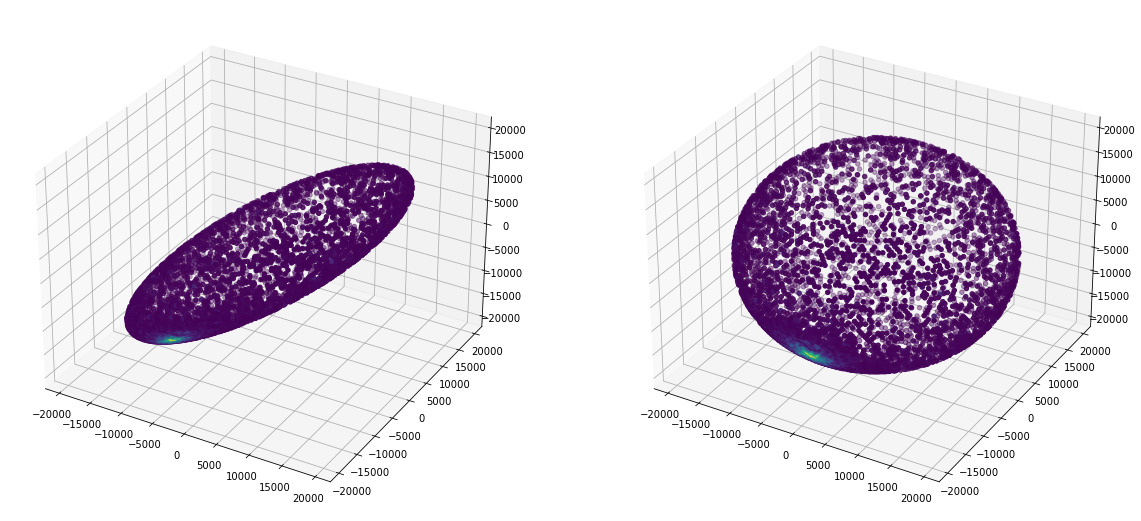

In [35]:
fig = plt.figure(figsize=(20,10))
axr = fig.add_subplot(121, projection='3d')
i=2
axr.scatter(
    xs = cc_df[cc_df.ev_id==i]['x_new'],
    ys = cc_df[cc_df.ev_id==i]['y_new'],
    zs = cc_df[cc_df.ev_id==i]['z_new'],
    c  = cc_df[cc_df.ev_id==i]['charge']
)
# axr.set_zlim(-3e4, 3e4)

axo = fig.add_subplot(122, projection='3d')
axo.scatter(
    xs = cc_df[cc_df.ev_id==i]['x'],
    ys = cc_df[cc_df.ev_id==i]['y'],
    zs = cc_df[cc_df.ev_id==i]['z'],
    c  = cc_df[cc_df.ev_id==i]['charge']

)
plt.show()

In [ ]:
ev_df['x_new']